<div class="alert alert-block alert-info">
This image set (<b>BBBC020</b>) contains examples of diverse morphologies of murine bone-marrow derived macrophages. The task is to develop an analysis pipeline to retrieve and quantitatively characterize these morphology groups. 
</div>

In [1]:
import os
import json
from glob import glob
from matplotlib.colors import ListedColormap
import numpy as np
from tqdm import tqdm
import tifffile
from FSD.utils import extract_data, visualize, invert_one_hot
from FSD.fsd import process, reconstruct_label_mask
from skimage.measure import perimeter

### Download Data

Images and corresponding instance segmentations (all of type `*.tif`) should be respectively present in sub-directories `images` and `masks`, which can be present at any location on your workstation, pointed to by the variables `data_dir` and `project_name`. 


In [2]:
data_dir = '../../../data'
project_name = 'BBBC020'

For the `BBBC020` dataset, we firstly download the data from an external url in the following cell.


In [3]:
# extract_data(
#     zip_url = 'https://github.com/lmanan/FSD/releases/download/v0.0.1/BBBC020.zip',
#     data_dir = data_dir,
#     project_name = project_name,
# )

### Investigate some of these images and corresponding instance segmentation masks

Load a `glasbey` style color map

In [3]:
new_cmp= np.load('../../../cmaps/cmap_60.npy')
new_cmp = ListedColormap(new_cmp)

In [4]:
%matplotlib inline
image_file_names = sorted(glob(os.path.join(data_dir, project_name, 'download', 'images','*.tif')))
mask_file_names = sorted(glob(os.path.join(data_dir, project_name, 'download', 'masks','*.tif')))

Change the `index` parameter between $0$ and $19$ to visualize other images and masks. There are, in total, $20$ images and corresponding masks.

Image filename is jw-15min 5_c1.tif and index is 4


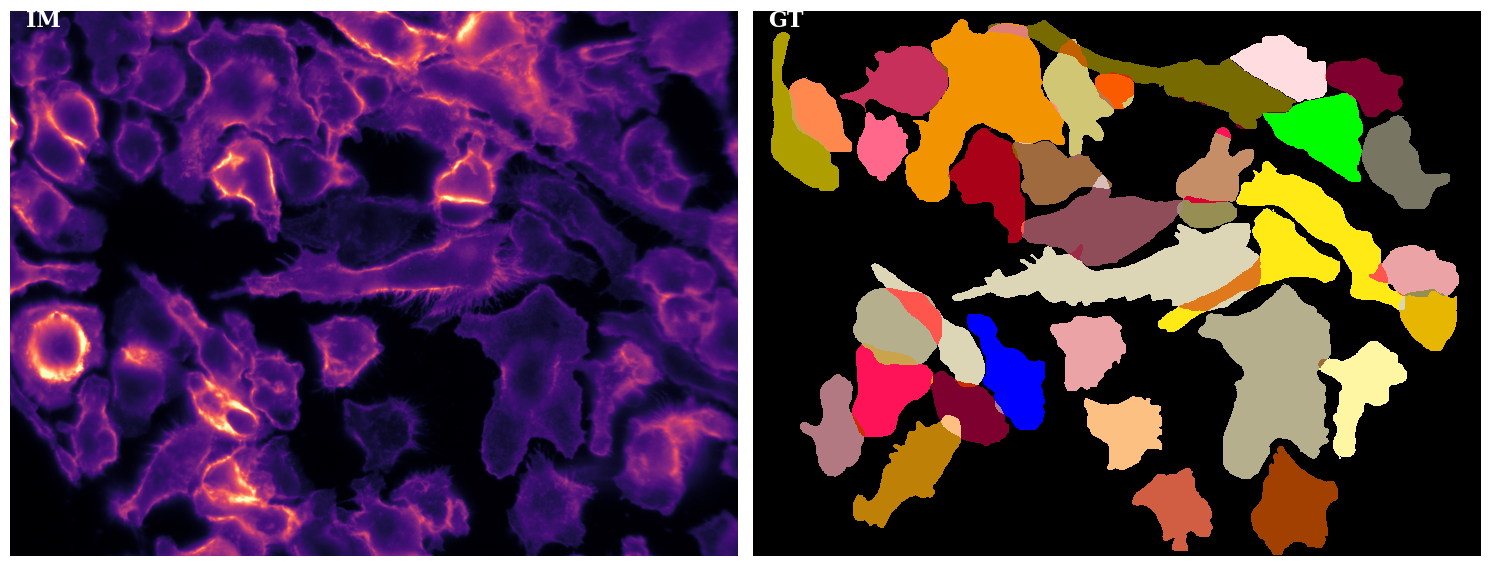

In [5]:
index = 4
print("Image filename is {} and index is {}".format(os.path.basename(image_file_names[index]), index))
image = tifffile.imread(image_file_names[index])
label_mask = tifffile.imread(mask_file_names[index])
visualize(image = image, ground_truth = invert_one_hot(label_mask), new_cmp = new_cmp)


### Convert shapes to Fourier Shape Descriptor (FSD) representations

We would like to study if there are any classes of diverse morphologies in this data-set. The task is to develop an analysis pipeline to retrieve and quantitatively characterize these morphology groups. <br>For this purpose, we use the `Fourier Shape Descriptor (FSD)` representation. This shape representation is obtained by going around the contour of each object one pixel at a time, storing the x and y coordinates of these boundary pixels, then performing a fourier analysis and finally investigating the obtained fourier coefficients. 

We process the complete available dataset through the `process` function. The frequency contributions are saved in the directory provided by the variable `fsd_dir_name` using this function.

In [6]:
fsd_dir_name = 'fsd/'

In [7]:
process(dir_name= os.path.join(data_dir, project_name, 'download'), fsd_dir_name = fsd_dir_name)

100%|███████████████████████████████████████████| 20/20 [00:45<00:00,  2.29s/it]


Now, that the frequency components are saved, we can investigate the fidelity of reconstruction for any arbitrary label mask. <br>
Change the `index` parameter multiple times, to visualize other images and masks. There are, in total, 20 images and corresponding masks.<br>
Please do, <u><b>vary</b></u> the number of frequencies (`num_frequencies`) to see the effect of this parameter while reconstructing the shape.

In [8]:
index = 4
num_frequencies = 32

Image filename is jw-15min 5_c1.tif and index is 4


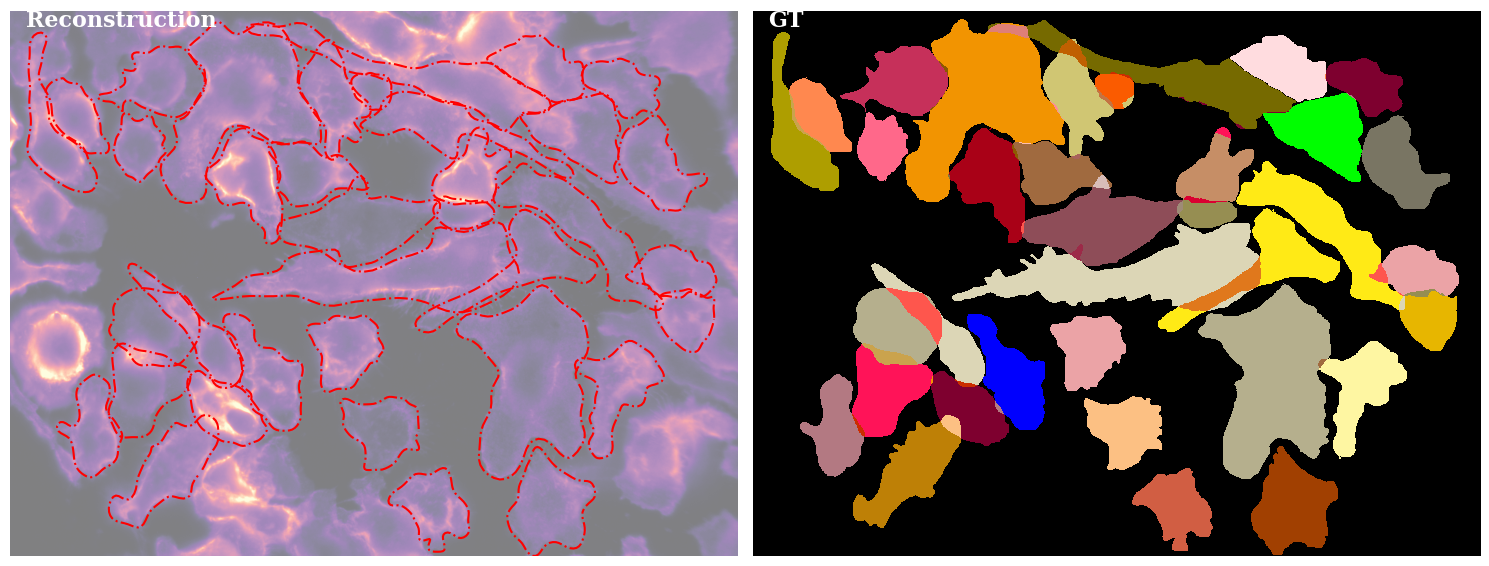

In [9]:
print("Image filename is {} and index is {}".format(os.path.basename(image_file_names[index]), index))
%matplotlib inline
reconstruct_label_mask(im_path = image_file_names[index], 
                       label_path = mask_file_names[index], 
                       fsd_dir_name= os.path.join(data_dir, project_name, 'download', fsd_dir_name), 
                       num_frequencies= num_frequencies, new_cmp = new_cmp)

### Clustering in the frequency space

Now that we are satisfied with the obtained reconstructions, we wonder whether we can identify individual morphologies in this dataset by clustering using a shape representation, which is a vector of size `num_frequencies`. <br>

Let's first put the vale of these features for all cells, in a table (`number of cells` $\times$ `num_frequencies`).

In [10]:
from FSD.cluster import create_tabular_data

In [11]:
table = create_tabular_data(os.path.join(data_dir, project_name, 'download', fsd_dir_name), num_frequencies=num_frequencies)
table= np.asarray(table)
print(table[0]) # an exemplary row of the table

['jw-15min 1_c1+00.npz' '0.11569573606342379' '0.2202108073734608'
 '0.13618093460773914' '0.111306775195533' '0.33728652125827036'
 '0.2041937159222573' '0.14079223437849425' '0.6086937232658121'
 '0.3626849576507341' '0.5081668875722903' '0.5696537870303261'
 '0.5063284624566861' '0.12868232996621382' '1.3330690729068582'
 '0.5430624097997042' '61.941825615133986' '1429.7281467674238'
 '3.6065239726761766' '0.9344436729330773' '2.457321564054979'
 '1.056849272790195' '1.0227477811955723' '0.12720074857344457'
 '0.8763813765147062' '0.12208274529302765' '0.24094724121879438'
 '0.3020093695959622' '0.05373713806495631' '0.07073134059241729'
 '0.29870934919414477' '0.25085182986617144' '0.0027286385001522584']


Here, the zeroth frequency contribution is a `DC` contribution which just encodes the position of that object. <br>
Since, we would like the shape representation to be <b><u>translation</u></b> invariant, we do not use this zeroth frequency contribution for identifying unique clusters.

In [12]:
tabular_data = np.delete(table, 0, 1) # take away the first column which carries the object names
tabular_data = np.delete(tabular_data, num_frequencies//2, 1) # also take away the DC contribution 

Next, let's see if any clusters emerge by performing **[UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html)**.

In [13]:
import umap
import matplotlib.pyplot as plt
from sklearn import cluster

In [14]:
reducer = umap.UMAP()
two_dimensional_embedding = reducer.fit_transform(tabular_data)

If one visually inspects the obtained two dimensional embeddings (`two_dimensional_embeddings`), there is not a very clear separation of the obtained morphology groups. This also makes sense since there is no disease and control groups per se for this dataset. <br> Visually however, one can almost see two clusters. Let's see what does performing k-means with `n_clusters=2` gives us.

In [15]:
kmeans_labels = cluster.KMeans(n_clusters=2).fit_predict(two_dimensional_embedding)

/home/manan/Softwares/anaconda3/envs/FSDEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


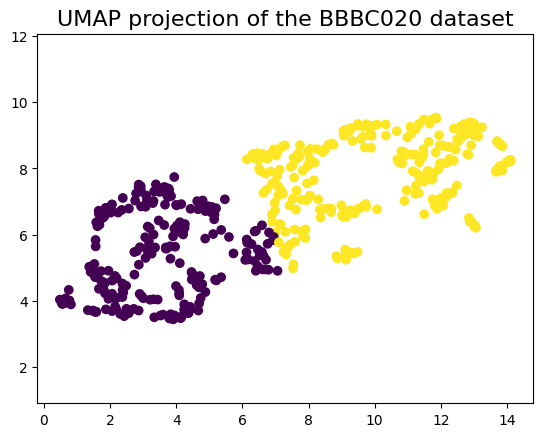

In [16]:
plt.scatter(
    two_dimensional_embedding[:, 0],
    two_dimensional_embedding[:, 1],
    c=kmeans_labels)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the BBBC020 dataset', fontsize=16);

### Let's quantify the properties of these two morphology groups 

The two class labels are either $0$ or $1$. Let's evaluate what is the average size, perimeter and measure of roundedness or circularity of objects within these two groups.
I use this definition of circularity ($1$ for circular objects, higher for non-circular objects):
$$ \text{Circularity} = \frac{\text{Perimeter}^2}{4\pi \times \text{Area}}$$.

In [17]:
indices_zero = np.where(kmeans_labels==0)[0]
indices_one = np.where(kmeans_labels==1)[0]

In [24]:
size_zero = []
perimeter_zero = []
size_one = []
perimeter_one = []

for index in tqdm(indices_zero):
    im_name = table[index, 0]
    label_mask = tifffile.imread(os.path.join(data_dir, project_name, 'download', 'masks', str.split(im_name, '+')[0]+'.tif'))
    ground_truth = label_mask[int(str.split(im_name, '+')[1][:-4])]
    y, x = np.where(ground_truth)
    size_zero.append(len(y))
    perimeter_zero.append(perimeter(ground_truth==255))
for index in tqdm(indices_one):
    im_name = table[index, 0]
    label_mask = tifffile.imread(os.path.join(data_dir, project_name, 'download', 'masks', str.split(im_name, '+')[0]+'.tif'))
    ground_truth = label_mask[int(str.split(im_name, '+')[1][:-4])]
    y, x = np.where(ground_truth)
    size_one.append(len(y))
    perimeter_one.append(perimeter(ground_truth==255))
print('='*30)
print("Average size of cells in group with assigned class 0 is {} \u00B1 {}".format(np.mean(size_zero), np.std(size_zero)))
print("Average perimeter of cells in group with assigned class 0 is {} \u00B1 {}".format(np.mean(perimeter_zero), np.std(perimeter_zero)))
circularity_zero = np.mean(perimeter_zero)**2/(4*np.pi*np.mean(size_zero))
print("Average circularity of cells in group with assigned class 0 is {}".format(circularity_zero))
print('='*30)
print("Average size of cells in group with assigned class 1 is {} \u00B1 {}".format(np.mean(size_one), np.std(size_one)))
print("Average perimeter of cells in group with assigned class 1 is {} \u00B1 {}".format(np.mean(perimeter_one), np.std(perimeter_one)))
circularity_one = np.mean(perimeter_one)**2/(4*np.pi*np.mean(size_one))
print("Average circularity of cells in group with assigned class 1 is {}".format(circularity_one))


100%|█████████████████████████████████████████| 279/279 [00:11<00:00, 24.68it/s]

Average size of cells in group with assigned class 0 is 29269.415254237287 ± 12211.477314066906
Average perimeter of cells in group with assigned class 0 is 966.2641249412562 ± 291.27233444362145
Average circularity of cells in group with assigned class 0 is 2.538445250210167 
Average size of cells in group with assigned class 1 is 13525.924731182795 ± 4982.041398835517
Average perimeter of cells in group with assigned class 1 is 522.7055892583094 ± 144.12361850958706
Average circularity of cells in group with assigned class 1 is 1.6074499431648264 


<div class="alert alert-block alert-info">
    <u><b>Conclusion</b></u> : it seems like within the two obtained clusters of morphology groups, class $0$ contains more non-circular and larger (in size) objects, while class $1$ contains more circular and smaller (in size) objects
</div>